In [1]:
#Importacions
import requests
import pandas as pd
import re, json, os
from collections import Counter

## Creació dataset

In [3]:
#with open('D:\Escritorio\Hack_UPC_2023\hackupc2023_restbai__dataset\hackupc2023_restbai__dataset_sample.json', encoding="utf8") as json_file:
with open('hackupc2023_restbai__dataset.json', encoding="utf8") as json_file:
    data = json.load(json_file)

dataset = [data[i] for i in data]
df = pd.DataFrame(dataset)

image_data = [i for i in df['image_data']]
image = pd.DataFrame(image_data)

a = []
for variable in image.columns:
    a.append([i for i in image[variable]])

r1r6 = pd.DataFrame(a[0])
style = pd.DataFrame(a[1])
features_by_room_type = pd.DataFrame(a[2])

### Preprocessing

In [4]:
for i in features_by_room_type.columns:
    features_by_room_type[i][features_by_room_type[i].isna()] = 0
    features_by_room_type[i][features_by_room_type[i] != 0] = 1

In [5]:
df[['property_quality', 'kitchen_quality', 'bathroom_quality', 'interior_quality']] = r1r6
df[['style_label', 'style_confidence']] = style
df[['outdoor_house', 'living-dining_room', 'kitchen', 'details', 'stairs',
       'empty_room', 'bathroom', 'room-bedroom', 'dining_room',
       'storage_pantry', 'parking', 'laundry_room', 'balcony', 'gym', 'garden',
       'living_room', 'hall-corridor', 'office', 'mountain_view',
       'outdoor_building', 'terrace', 'documents', 'energy_certificate',
       '2D_floor_plan', 'reception-lobby', 'water_view', 'non_related', 'pool',
       'walk_in_closet', 'map_location', 'cellar', '3D_floor_plan']] = features_by_room_type
df = df.drop(columns='image_data')

In [6]:
df['summary'] = df['summary'].apply(lambda x: x.split()[0])

In [8]:
import nltk
categorical=[]
for data in df['summary']:
    a = nltk.word_tokenize(data)
    categorical.append(a[0])

In [9]:
cat = pd.DataFrame(categorical,columns=['summary'])
df['summary']=cat

In [10]:
a = pd.get_dummies(df['summary'])
noves=list(a.columns)
df[noves]=a

In [11]:
numeric_cols = df.select_dtypes(include=['int', 'float']).columns
numeric_df = df[numeric_cols]
#numeric_df[numeric_df['property_quality'].isna()]
#numeric_df[numeric_df['kitchen_quality'].isna()]
#numeric_df[numeric_df['bathroom_quality'].isna()]
#numeric_df[numeric_df['interior_quality'].isna()]
#numeric_df[numeric_df['style_confidence'].isna()]

numeric_df=numeric_df[numeric_df.columns[0:5]]

In [12]:
from sklearn.preprocessing import StandardScaler

nums=list(numeric_df.columns)
scaler = StandardScaler()
df[nums] = scaler.fit_transform(df[nums])
numeric_df=df[nums]

In [13]:
df_concatenado = pd.concat([numeric_df, df.iloc[:, -38:]], axis=1, join='inner', ignore_index=True)
df_concatenado 

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0.021955,-0.005384,0.285217,0.535626,1.759901,1,1,1,1,1,...,0,0,1,0,0,0,0,0,0,0
1,-0.389209,-0.013736,-0.436461,-0.458626,0.122954,0,0,0,1,1,...,0,0,0,0,0,0,0,0,1,0
2,-0.491999,-0.013048,-0.436461,-0.458626,-0.695519,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0.302060,-0.007824,0.285217,0.535626,2.332832,1,1,0,1,1,...,0,0,1,0,0,0,0,0,0,0
4,0.201839,-0.008443,0.285217,0.535626,0.941427,0,1,1,1,1,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668671,0.710910,0.164095,NaN,NaN,-0.695519,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
668672,NaN,0.134365,NaN,NaN,0.041107,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
668673,NaN,0.123435,NaN,NaN,-0.449977,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
668674,2.848701,-0.004181,0.646056,0.038500,-0.695519,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


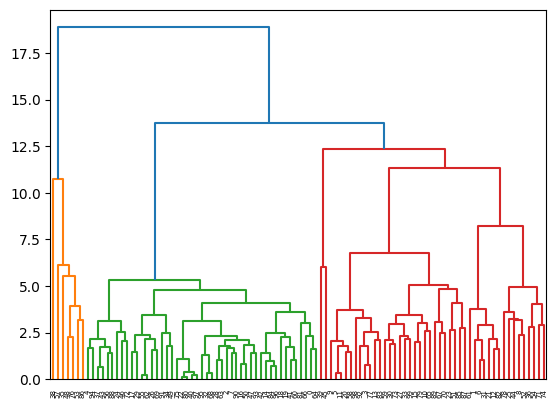

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
linkage_data = linkage(df_concatenado, method='ward', metric='euclidean')
dendrogram(linkage_data)

plt.show()

In [14]:
df_concatenado.to_csv('dataset.csv')

## API extract information

In [15]:
def extract_data(images):
    url = 'https://property.restb.ai/v1/multianalyze'
    payload = {
    # Add your client key
    'client_key': '9619d3ad888f538de7f61f7a3b718dc0c70c4334ae8c704daff48788f68c7f0a'
    }
    request_body = {
    "image_urls": images,
    "solutions": {"roomtype": 1.0, "roomtype_reso": 1.0, "style": 1.0, "r1r6": None, "c1c6": None, "features": 4.0, "features_reso": 1.0,  "caption": None}
    }

    # Make the classify request
    response = requests.post(url, params=payload, json=request_body)

    # The response is formatted in JSON
    json_response = response.json()
    return json_response

In [16]:
def extract_dataframe(images):
    json_response = extract_data(images)
    data = re.sub("'", '"',str(json_response))
    data = re.sub(r'([a-z]+)"([a-z]+)', r"\1'\2",data)
    data = re.sub('False','false',data)
    data = re.sub('None','null',data)
    data = re.sub('True','true',data)
    with open('output.json', 'w') as file:
        file.write(data)
    df = pd.read_json('output.json')
    pd.set_option('display.max_colwidth', None)
    datos = df['response']['solutions']
    datos = re.sub("'", '"',str(datos))
    datos = re.sub(r'([a-z]+)"([a-z]+)', r"\1'\2",datos)
    datos = re.sub('False','false',datos)
    datos = re.sub('None','null',datos)
    datos = re.sub('True','true',datos)
    with open('response.json', 'w') as file:
        file.write(datos)
    df0 = pd.read_json('response.json')
    return df0

In [17]:
def extract_poques(images):
    df0 = extract_dataframe(images)
    features = {}
    features_var = df0['features']['results']
    features_reso = df0['features_reso']['summary']['lookup_fields']
    room_type = df0['roomtype']['results']
    room_type_reso = df0['roomtype_reso']['results']

    for json_data in features_var:
        detections = json_data['values']['detections']
        for detection in detections:
            label = detection['label']
            if not label in features:
                features[f'api_{label}'] = 1
    for lookup_field in features_reso:
        label = lookup_field['lookup_value'][0]['label']
        if not label in features:
            features[f'api_{label}'] = 1

    for item in room_type:
        label = item['values']['top_prediction']['label']
        if not label in features:
            features[f'api_{label}'] = 1

    for item in room_type_reso:
        label = item['values']['top_prediction']['label']
        if not label in features:
            features[f'api_{label}'] = 1
            
    return features


In [18]:
dades = df[0:1]
dades = dades.join(dades['images'].apply(lambda x: pd.Series(extract_poques(x))), rsuffix='_suffix')
for i in range(2,201):
    dd = df[i-1:i]
    dd = dd.join(dd['images'].apply(lambda x: pd.Series(extract_poques(x))), rsuffix='_suffix')
    dades = pd.concat([dades, dd], ignore_index=True)

In [19]:
b = []
for i in dades.columns:
    b.append(i)
contador = Counter(b)

In [20]:
b = []
for i in dades.columns:
    b.append(re.sub('api_','',i))
contador = Counter(b)
# Mostrar los resultados
while len(contador) > 0:
    elem = contador.most_common(1)[0][0]
    if contador[elem]>1:
        dades = dades.drop(f'api_{elem}',axis=1)
    del contador[elem]

In [21]:
dades.to_csv('dataset_api.csv')

In [22]:
nums=list(numeric_df.columns)
scaler = StandardScaler()
dades[nums] = scaler.fit_transform(dades[nums])
numeric_df=dades[nums]

In [23]:
fr = pd.DataFrame()
for i in dades.columns:
    if i in df.columns:
        fr[i] = dades[i]

In [24]:
new = pd.DataFrame()
for i in dades.columns:
    if not i in df.columns:
        new[i] = dades[i]

C:\Users\llumf\AppData\Local\Temp\ipykernel_940\53571446.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new[i] = dades[i]
C:\Users\llumf\AppData\Local\Temp\ipykernel_940\53571446.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new[i] = dades[i]
C:\Users\llumf\AppData\Local\Temp\ipykernel_940\53571446.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. 

In [25]:
few_na = new.dropna(axis=1, thresh=4).columns

In [26]:
for col in few_na:
    del new[col]

In [27]:
new

,api_concrete_wall,api_kitchen_island,api_separate_washer__dryer,api_outdoor_bar,api_KitchenIsland,api_InGarage,api_Sheds,api_porch,api_FrontPorch,api_Refrigerator,...,api_StoneCounters,api_BasketballCourt,api_detached_carport,api_Carport,api_ExerciseRoom,api_Range,api_AttachedCarport,api_sunroom,api_kitchen_bar,api_BreakfastBar
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
